# Creating dataset to analyze bike sharing demand in Washington D.C.

In [102]:
import pandas as pd
import glob
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import seaborn as sb
import matplotlib.pyplot as plt


In [3]:
# display all rows and columns in the dataframes
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)


## Bike sharing demand dataset

In [4]:
# merge the bike sharing demand csv files into one dataframe for Washington, D.C.
path = r'C:\Users\julia\Documents\Studium\Master\2. Semester\Master-Seminar Applied Econometrics - Data Science Basics\bike-sharing\datasets\bike-sharing'
all_files = glob.glob(path + "/*.csv")

df_list = []

for file in all_files:
    df_comp = pd.read_csv(file)
    df_list.append(df_comp)
    
df_bike = pd.concat(df_list, axis=0, ignore_index=True)


In [5]:
# get overview of dataframe
print(df_bike.shape)
df_bike.head()


(22544730, 9)


,Duration,Start date,End date,Start station number,Start station,End station number,End station,Bike number,Member type
0,3548,2011-01-01 00:01:29,2011-01-01 01:00:37,31620,5th & F St NW,31620,5th & F St NW,W00247,Member
1,346,2011-01-01 00:02:46,2011-01-01 00:08:32,31105,14th & Harvard St NW,31101,14th & V St NW,W00675,Casual
2,562,2011-01-01 00:06:13,2011-01-01 00:15:36,31400,Georgia & New Hampshire Ave NW,31104,Adams Mill & Columbia Rd NW,W00357,Member
3,434,2011-01-01 00:09:21,2011-01-01 00:16:36,31111,10th & U St NW,31503,Florida Ave & R St NW,W00970,Member
4,233,2011-01-01 00:28:26,2011-01-01 00:32:19,31104,Adams Mill & Columbia Rd NW,31106,Calvert & Biltmore St NW,W00346,Casual


In [20]:
# drop columns that are irrelevant
df_bike_drop = df_bike.drop(['Duration', 'Start station', 'End station number', 
                             'End station', 'Bike number', 'End date'], axis=1)

# create new column that only contains the date
df_bike_drop['date'] = df_bike_drop['Start date'].apply(lambda x: x[:10])

# drop the Start date column
df_bike_drop.drop(['Start date'], axis=1, inplace=True)




In [24]:
# read in dataset that contains location information on bike stations
bike_station_df = pd.read_csv('datasets/bike-stations/Capital_Bike_Share_Locations.csv')
bike_station_df.head()


,OBJECTID,ID,ADDRESS,TERMINAL_NUMBER,LATITUDE,LONGITUDE,INSTALLED,LOCKED,INSTALL_DATE,REMOVAL_DATE,TEMPORARY_INSTALL,NUMBER_OF_BIKES,NUMBER_OF_EMPTY_DOCKS,X,Y,SE_ANNO_CAD_DATA,OWNER
0,292811730,479,Columbus Ave & Gramercy Blvd,32069,39.123330,-77.164860,YES,NO,NaN,NaN,NO,8,3,385744.186615,161710.152819,NaN,NaN
1,292811731,480,Reston Pkwy & Spectrum Dr,32225,38.964208,-77.354280,YES,NO,NaN,NaN,NO,5,10,369296.122237,144092.525801,NaN,NaN
2,292811732,481,Key West Ave & Great Seneca Hwy,32070,39.105642,-77.203860,YES,NO,NaN,NaN,NO,3,7,382367.389360,159753.369415,NaN,NaN
3,292811733,482,Virginia Ave & 25th St NW,31297,38.899500,-77.054155,YES,NO,NaN,NaN,NO,12,7,395302.353355,136851.190868,NaN,DC
4,292811734,483,15th & M St NW,31298,38.905424,-77.034674,YES,NO,NaN,NaN,NO,10,9,396992.472005,137507.980428,NaN,DC


In [25]:
# drop all irrelevant columns
bike_station_df_drop = bike_station_df.drop(['OBJECTID', 'ID', 'INSTALLED', 'LOCKED', 'INSTALL_DATE',
                                             'REMOVAL_DATE', 'TEMPORARY_INSTALL', 'NUMBER_OF_BIKES',
                                             'NUMBER_OF_EMPTY_DOCKS', 'X', 'Y', 'SE_ANNO_CAD_DATA',
                                             'OWNER'], axis=1)

bike_station_df_drop.head()


,ADDRESS,TERMINAL_NUMBER,LATITUDE,LONGITUDE
0,Columbus Ave & Gramercy Blvd,32069,39.123330,-77.164860
1,Reston Pkwy & Spectrum Dr,32225,38.964208,-77.354280
2,Key West Ave & Great Seneca Hwy,32070,39.105642,-77.203860
3,Virginia Ave & 25th St NW,31297,38.899500,-77.054155
4,15th & M St NW,31298,38.905424,-77.034674


In [108]:
# rename TERMINAL_NUMBER column to Start Station for merging preparation
bike_station_df_drop.rename(columns={'TERMINAL_NUMBER': 'Start station number'}, inplace=True)
bike_station_df_drop_final = bike_station_df_drop.drop(columns=['ADDRESS', 'Start station number', 'dataset'])
bike_station_df_drop_final.head()


,LATITUDE,LONGITUDE
0,39.123330,-77.164860
1,38.964208,-77.354280
2,39.105642,-77.203860
3,38.899500,-77.054155
4,38.905424,-77.034674


In [113]:
(bike_station_df_drop_final['LONGITUDE'] == 0).sum()

0

In [83]:
all_kmeans = []
num_clust = 40
for i in range(1,num_clust):
    # run k-means clustering on the data and...
    kmeans_i = KMeans(n_clusters=i, random_state=42)
    # compute the average within-cluster distances.
    print(kmeans_i)
    model_i = kmeans_i.fit(bike_station_df_drop_final).score(bike_station_df_drop_final)
    all_kmeans.append(model_i)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=1, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)
KMeans(algorithm='auto', copy_x=True, init='k

In [125]:
# prepare data to be plotted
num_clust = [x for x in range(1,40)]
all_kmeans_new = [-x for x in all_kmeans]

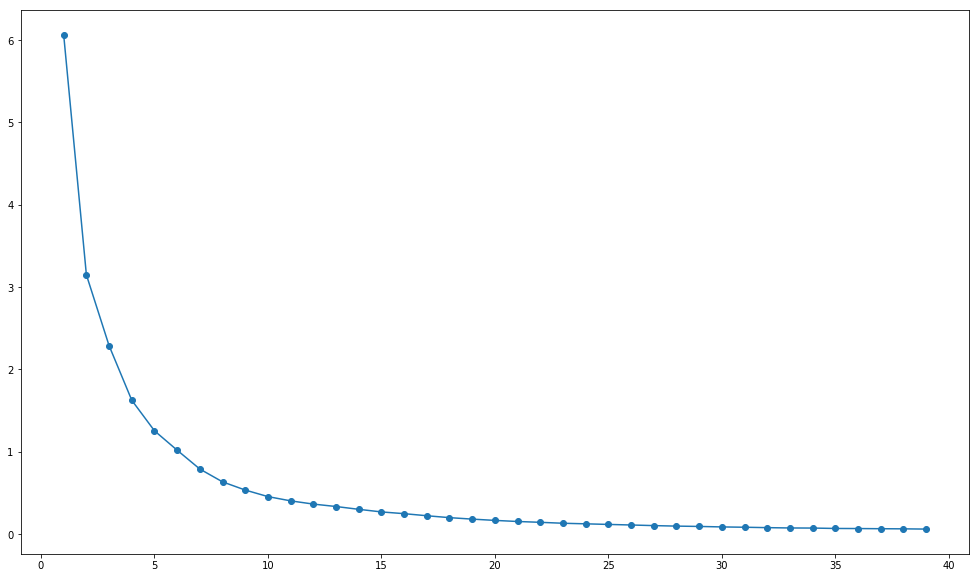

In [85]:
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.figure(figsize=(17,10))
plt.plot(num_clust, all_kmeans_new, marker='o')

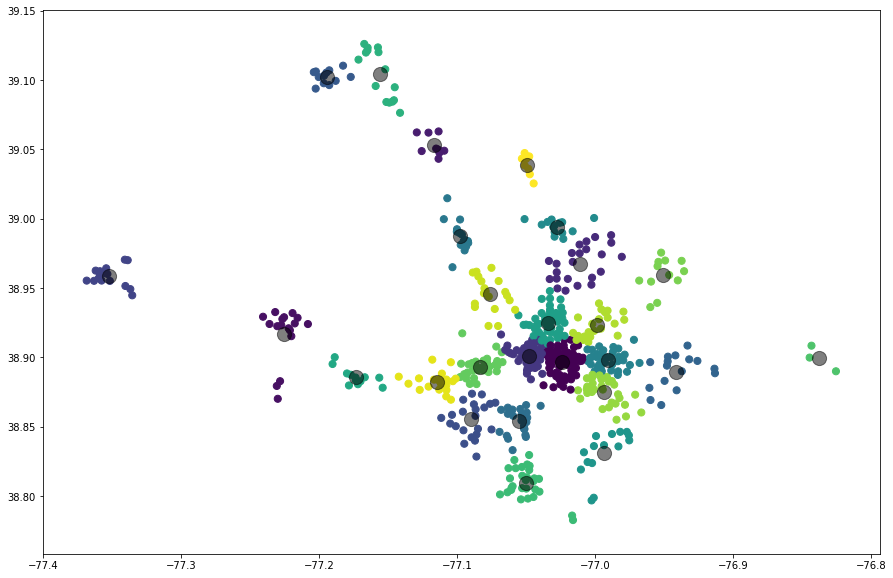

In [134]:
kmeans = KMeans(n_clusters=26)
kmeans.fit(bike_station_df_drop_final)
y_kmeans = kmeans.predict(bike_station_df_drop_final)

plt.figure(figsize=(15,10))
plt.scatter(bike_station_df_drop_final['LONGITUDE'], 
            bike_station_df_drop_final['LATITUDE'], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 1], centers[:, 0], c='black', s=200, alpha=0.5);


In [119]:
total_scores = []
for i in range(2,40):
    clusterer = KMeans(n_clusters=i, random_state=42)
    preds = clusterer.fit_predict(bike_station_df_drop_final)
    centers = clusterer.cluster_centers_

    score = silhouette_score(bike_station_df_drop_final, preds, metric='euclidean')
    total_scores.append(score)
    print ("For n_clusters = {}, silhouette score is {})".format(i, score))

For n_clusters = 2, silhouette score is 0.6005110877253983)
For n_clusters = 3, silhouette score is 0.5786439989005002)
For n_clusters = 4, silhouette score is 0.40334655340608633)
For n_clusters = 5, silhouette score is 0.41117797107922893)
For n_clusters = 6, silhouette score is 0.41835352389379443)
For n_clusters = 7, silhouette score is 0.4070196202053189)
For n_clusters = 8, silhouette score is 0.4353822385774991)
For n_clusters = 9, silhouette score is 0.4495844781190487)
For n_clusters = 10, silhouette score is 0.4544670158528923)
For n_clusters = 11, silhouette score is 0.4586608042175479)
For n_clusters = 12, silhouette score is 0.45067735389947144)
For n_clusters = 13, silhouette score is 0.45886598261021216)
For n_clusters = 14, silhouette score is 0.45837025670164944)
For n_clusters = 15, silhouette score is 0.4514252926974311)
For n_clusters = 16, silhouette score is 0.45217929413971336)
For n_clusters = 17, silhouette score is 0.4436811558355293)
For n_clusters = 18, silh

In [126]:
num_clust.pop(0)
num_clust


[2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39]

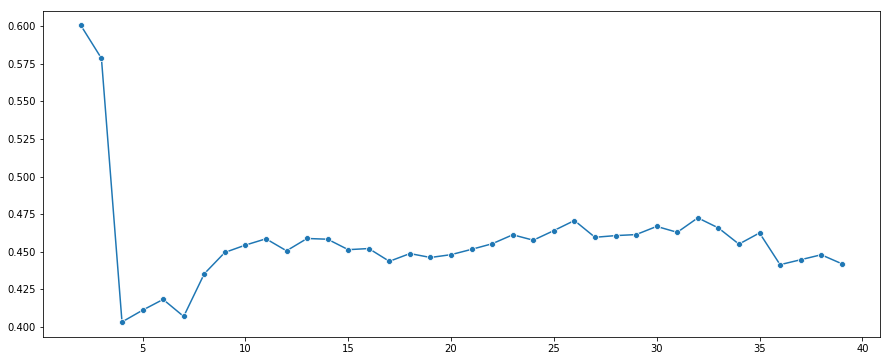

In [133]:
# plotting the silhouette scores
plt.figure(figsize=[15,6])
sb.lineplot(num_clust, total_scores, marker='o');

In [27]:
# merge df_bike_drop and bike_station_df_drop on the start station column
df_demand_station = df_bike_drop.merge(bike_station_df_drop, how='left', on='Start station number')
df_demand_station.head()


,Start station number,Member type,date,ADDRESS,LATITUDE,LONGITUDE
0,31620,Member,2011-01-01,5th & F St NW,38.897222,-77.019347
1,31105,Casual,2011-01-01,14th & Harvard St NW,38.926800,-77.032200
2,31400,Member,2011-01-01,Georgia & New Hampshire Ave NW,38.936043,-77.024649
3,31111,Member,2011-01-01,10th & U St NW,38.917200,-77.025900
4,31104,Casual,2011-01-01,Adams Mill & Columbia Rd NW,38.922925,-77.042581


We're not using Washington, D.C., neighborhoods to cluster the bike stations because the stations are also located outside of the city boundaries. The capital bikeshare dataset covers 7 jurisdictions in the metro DC area: Washington, DC.; Arlington, VA; Alexandria, VA; Montgomery, MD; Prince George's County, MD; Fairfax County, VA; and the City of Falls Church, VA.(https://www.capitalbikeshare.com/how-it-works)

Also, the weather data includes stations in these areas, so the average daily weather has been included for all locations. (See station list of weather dataset)

According to (https://secure.capitalbikeshare.com/map/), the map matches the clustering plot.


In [38]:
# create two new columns for number of casual and registered customers per day
df_bike_drop['casual'] = df_bike_drop['Member type'].apply(lambda x: 1 if x == 'Casual' else 0)
df_bike_drop['registered'] = df_bike_drop['Member type'].apply(lambda x: 1 if x == 'Member' else 0)

# create new dataframe with date, casual, registered and total customers
cust_list = ['casual', 'registered']
df_bike_list = []

for cust in cust_list:
    series_bike_users = df_bike_drop.groupby('date')[cust].sum()
    df_bike_users = series_bike_users.to_frame()
    df_bike_list.append(df_bike_users)
    
# concat both dataframes saved in list and add new column containing total number of customers
df_bike_cust = pd.concat(df_bike_list, axis=1)
df_bike_cust.reset_index(inplace=True)
df_bike_cust['total_cust'] = df_bike_cust['casual'] + df_bike_cust['registered']
df_bike_cust



,date,casual,registered,total_cust
0,2011-01-01,330,629,959
1,2011-01-02,130,651,781
2,2011-01-03,120,1181,1301
3,2011-01-04,107,1429,1536
4,2011-01-05,82,1489,1571
5,2011-01-06,88,1485,1573
6,2011-01-07,148,1345,1493
7,2011-01-08,68,871,939
8,2011-01-09,54,748,802
9,2011-01-10,41,1257,1298


## Holiday dataset

In [39]:
# manual creation of dataframe containing information on holidays in Washington, D.C.
# source for this is https://dchr.dc.gov/page/holiday-schedules-2018, https://dchr.dc.gov/page/holiday-schedules-2016-and-2017
# https://dchr.dc.gov/page/holiday-schedules-2014-and-2015, https://dchr.dc.gov/page/holiday-schedules-2012-and-2013
# https://dchr.dc.gov/page/holiday-schedules-2010-and-2011

df_holiday = pd.DataFrame(columns=['date', 'holiday'])

dates = ['2018-01-01', '2018-01-15', '2018-02-19', '2018-04-16',
         '2018-05-28', '2018-07-04', '2018-09-03', '2018-10-08',
         '2018-11-12', '2018-11-22', '2018-12-25', '2017-01-02',
         '2017-01-16', '2017-01-20', '2017-02-20', '2017-04-17',
         '2017-05-29', '2017-07-04', '2017-09-04', '2017-10-09',
         '2017-11-10', '2017-11-23', '2017-12-25', '2016-01-01',
         '2016-01-18', '2016-02-15', '2016-04-15', '2016-05-30',
         '2016-07-04', '2016-09-05', '2016-10-10', '2016-11-11',
         '2016-11-24', '2016-12-26', '2015-01-01', '2015-01-19',
         '2015-02-16', '2015-04-16', '2015-05-25', '2015-07-03',
         '2015-09-07', '2015-10-12', '2015-11-11', '2015-11-26',
         '2015-12-25', '2014-01-01', '2014-01-20', '2014-02-17',
         '2014-04-16', '2014-05-26', '2014-07-04', '2014-09-01', 
         '2014-10-13', '2014-11-11', '2014-11-27', '2014-12-25',
         '2013-01-01', '2013-01-21', '2013-01-20', '2013-02-18', 
         '2013-04-16', '2013-05-27', '2013-07-04', '2013-09-02',
         '2013-10-14', '2013-11-11', '2013-11-28', '2013-12-25',
         '2012-01-02', '2012-01-16', '2012-02-20', '2012-04-16',
         '2012-05-28', '2012-07-04', '2012-09-03', '2012-10-08',
         '2012-11-12', '2012-11-22', '2012-12-25', '2011-01-17',
         '2011-02-21', '2011-04-15', '2011-05-30', '2011-07-04',
         '2011-09-05', '2011-10-10', '2011-11-11', '2011-11-24',
         '2011-12-26']

df_holiday['date'] = dates
df_holiday['holiday'] = 1
df_holiday.head()


,date,holiday
0,2018-01-01,1
1,2018-01-15,1
2,2018-02-19,1
3,2018-04-16,1
4,2018-05-28,1


## Weather dataset

In [71]:
# read in the weather data for Washington, D.C.
path = r'C:\Users\julia\Documents\Studium\Master\2. Semester\Master-Seminar Applied Econometrics - Data Science Basics\bike-sharing\datasets\weather-data'
all_files = glob.glob(path + "/*.csv")

df_list_weather = []

for file in all_files:
    df_comp_weather = pd.read_csv(file, low_memory=False)
    df_list_weather.append(df_comp_weather)
    
df_weather = pd.concat(df_list_weather, axis=0, ignore_index=True, sort=False)


In [72]:
# number of rows and columns in weather dataframe
df_weather.shape


(268114, 54)

In [73]:
# get an idea of the datatypes on the weather dataframe
df_weather.dtypes


STATION             object
NAME                object
LATITUDE           float64
LONGITUDE          float64
ELEVATION          float64
DATE                object
AWND               float64
AWND_ATTRIBUTES     object
PRCP               float64
PRCP_ATTRIBUTES     object
TAVG               float64
TAVG_ATTRIBUTES     object
TMAX               float64
TMAX_ATTRIBUTES     object
TMIN               float64
TMIN_ATTRIBUTES     object
TOBS               float64
TOBS_ATTRIBUTES     object
WT01               float64
WT01_ATTRIBUTES     object
WT02               float64
WT02_ATTRIBUTES     object
WT03               float64
WT03_ATTRIBUTES     object
WT04               float64
WT04_ATTRIBUTES     object
WT05               float64
WT05_ATTRIBUTES     object
WT06               float64
WT06_ATTRIBUTES     object
WT08               float64
WT08_ATTRIBUTES     object
WT09               float64
WT09_ATTRIBUTES     object
WT11               float64
WT11_ATTRIBUTES     object
WT13               float64
W

In [74]:
df_weather.describe(include='all')

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,AWND,AWND_ATTRIBUTES,PRCP,PRCP_ATTRIBUTES,TAVG,TAVG_ATTRIBUTES,TMAX,TMAX_ATTRIBUTES,TMIN,TMIN_ATTRIBUTES,TOBS,TOBS_ATTRIBUTES,WT01,WT01_ATTRIBUTES,WT02,WT02_ATTRIBUTES,WT03,WT03_ATTRIBUTES,WT04,WT04_ATTRIBUTES,WT05,WT05_ATTRIBUTES,WT06,WT06_ATTRIBUTES,WT08,WT08_ATTRIBUTES,WT09,WT09_ATTRIBUTES,WT11,WT11_ATTRIBUTES,WT13,WT13_ATTRIBUTES,WT14,WT14_ATTRIBUTES,WT16,WT16_ATTRIBUTES,WT17,WT17_ATTRIBUTES,WT18,WT18_ATTRIBUTES,WT21,WT21_ATTRIBUTES,WT22,WT22_ATTRIBUTES,WT15,WT15_ATTRIBUTES,WT19,WT19_ATTRIBUTES
count,268114,268114,268114.000000,268114.000000,268114.000000,268114,11506.000000,11506,263107.000000,263107,6150.000000,6150,42469.000000,42469,42456.000000,42456,31298.000000,31298,3911.0,3911,328.0,328,1959.0,1959,295.0,295,58.0,58,266.0,266,985.0,985,12.0,12,346.0,346,800.0,800,229.0,229,1032.0,1032,9.0,9,178.0,178,41.0,41,10.0,10,9.0,9,1.0,1
unique,223,222,NaN,NaN,NaN,2922,NaN,3,NaN,44,NaN,1,NaN,7,NaN,7,NaN,13,NaN,4,NaN,2,NaN,4,NaN,5,NaN,4,NaN,3,NaN,2,NaN,1,NaN,3,NaN,1,NaN,1,NaN,1,NaN,1,NaN,1,NaN,1,NaN,1,NaN,1,NaN,1
top,USW00093721,"WASHINGTON REAGAN NATIONAL AIRPORT, VA US",NaN,NaN,NaN,2017-07-29,NaN,",,W",NaN,",,N",NaN,"H,,S",NaN,",,7",NaN,",,7",NaN,",,7,0700",NaN,",,W",NaN,",,W",NaN,",,7",NaN,",,7",NaN,",,7",NaN,",,7",NaN,",,W",NaN,",,W",NaN,",,7",NaN,",,X",NaN,",,X",NaN,",,X",NaN,",,X",NaN,",,X",NaN,",,X",NaN,",,X",NaN,",,X",NaN,",,X"
freq,2922,2922,NaN,NaN,NaN,118,NaN,10776,NaN,206670,NaN,6150,NaN,28426,NaN,28411,NaN,12594,NaN,2992,NaN,240,NaN,1026,NaN,159,NaN,29,NaN,207,NaN,797,NaN,12,NaN,295,NaN,800,NaN,229,NaN,1032,NaN,9,NaN,178,NaN,41,NaN,10,NaN,9,NaN,1
mean,NaN,NaN,38.971833,-76.989676,81.557438,NaN,3.166974,NaN,3.721575,NaN,14.312520,NaN,18.989263,NaN,8.445051,NaN,11.000150,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN
std,NaN,NaN,0.194212,0.252576,49.302938,NaN,1.510937,NaN,10.440575,NaN,9.635069,NaN,10.127129,NaN,9.679169,NaN,9.750956,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN
min,NaN,NaN,38.467400,-77.497598,0.000000,NaN,0.200000,NaN,0.000000,NaN,-12.900000,NaN,-11.700000,NaN,-20.000000,NaN,-18.300000,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN
25%,NaN,NaN,38.847200,-77.183060,43.900000,NaN,2.100000,NaN,0.000000,NaN,6.500000,NaN,10.600000,NaN,0.600000,NaN,2.800000,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN
50%,NaN,NaN,38.991000,-77.010883,83.200000,NaN,2.900000,NaN,0.000000,NaN,15.300000,NaN,20.000000,NaN,8.300000,NaN,11.700000,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN
75%,NaN,NaN,39.114700,-76.784300,115.800000,NaN,4.000000,NaN,2.000000,NaN,23.000000,NaN,27.800000,NaN,17.200000,NaN,19.400000,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN


In [75]:
# show all available weather situation columns and create a list without the attribute columns
weathersit_list = list(df_weather.columns)[12:]
weathersit = [x for x in weathersit_list if len(x) < 5 and 'WT' in x]
weathersit


['WT01',
 'WT02',
 'WT03',
 'WT04',
 'WT05',
 'WT06',
 'WT08',
 'WT09',
 'WT11',
 'WT13',
 'WT14',
 'WT16',
 'WT17',
 'WT18',
 'WT21',
 'WT22',
 'WT15',
 'WT19']

In [76]:
# create a new data frame that contains only average temperature, windspeed, precipitation and weathersituation
# per day across all stations in Washington, D.C.
var_list = ['TAVG', 'TMIN', 'TMAX', 'TOBS', 'PRCP', 'AWND', weathersit]
df_avg_list = []

for var in var_list:
    if type(var) != list:
        data_avg_vars = df_weather.groupby('DATE')[var].mean()
        df_avg_vars = data_avg_vars.to_frame()
        df_avg_list.append(df_avg_vars)
    else:
        for sit in weathersit:
            data_wsit = df_weather.groupby('DATE')[sit].max()
            df_wsit = data_wsit.to_frame()
            df_avg_list.append(df_wsit)
            
df_weather_aggr = pd.concat(df_avg_list, axis=1)
df_weather_aggr


,TAVG,TMIN,TMAX,TOBS,PRCP,AWND,WT01,WT02,WT03,WT04,WT05,WT06,WT08,WT09,WT11,WT13,WT14,WT16,WT17,WT18,WT21,WT22,WT15,WT19
DATE,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-01,NaN,-1.566667e+00,11.973333,2.772727,0.069333,2.575000,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-02,NaN,8.800000e-01,13.806667,7.327273,1.037349,3.925000,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-03,NaN,-3.442857e+00,7.464286,-3.060000,1.878824,3.625000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-04,NaN,-5.957143e+00,4.642857,-3.100000,0.000000,1.800000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-05,NaN,-4.293333e+00,6.113333,-1.772727,0.000000,2.950000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-06,NaN,-4.993333e+00,4.233333,-4.245455,0.000000,1.600000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
2011-01-07,NaN,-3.885714e+00,2.857143,-1.570000,0.101205,2.550000,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
2011-01-08,NaN,-3.980000e+00,0.486667,-2.472727,0.285057,4.575000,1.0,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN
2011-01-09,NaN,-6.293333e+00,0.226667,-6.072727,0.283529,6.425000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [77]:
# reset index and change column names
df_weather_aggr.reset_index(inplace=True)

df_weather_aggr = df_weather_aggr.rename(columns={'DATE': 'date', 'TAVG': 'temp_avg', 'TMAX': 'temp_max',
                                                  'TMIN': 'temp_min', 'TOBS': 'temp_observ', 'PRCP': 'precip', 
                                                  'AWND': 'wind','WT01': 'wt_fog', 'WT02': 'wt_heavy_fog', 
                                                  'WT03': 'wt_thunder', 'WT04': 'wt_sleet', 'WT05': 'wt_hail', 
                                                  'WT06': 'wt_glaze', 'WT08':'wt_haze', 'WT09':'wt_drift_snow', 
                                                  'WT11': 'wt_high_wind', 'WT13': 'wt_mist', 'WT14': 'wt_drizzle', 
                                                  'WT15': 'wt_freeze_drizzle', 'WT16': 'wt_rain', 'WT17': 'wt_freeze_rain', 
                                                  'WT18': 'wt_snow', 'WT19': 'wt_unknown', 'WT21': 'wt_ground_fog', 
                                                  'WT22': 'wt_ice_fog'})
df_weather_aggr.head()


,date,temp_avg,temp_min,temp_max,temp_observ,precip,wind,wt_fog,wt_heavy_fog,wt_thunder,wt_sleet,wt_hail,wt_glaze,wt_haze,wt_drift_snow,wt_high_wind,wt_mist,wt_drizzle,wt_rain,wt_freeze_rain,wt_snow,wt_ground_fog,wt_ice_fog,wt_freeze_drizzle,wt_unknown
0,2011-01-01,NaN,-1.566667,11.973333,2.772727,0.069333,2.575,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2011-01-02,NaN,0.880000,13.806667,7.327273,1.037349,3.925,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2011-01-03,NaN,-3.442857,7.464286,-3.060000,1.878824,3.625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011-01-04,NaN,-5.957143,4.642857,-3.100000,0.000000,1.800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2011-01-05,NaN,-4.293333,6.113333,-1.772727,0.000000,2.950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [81]:
# check the shape of the above dataframe
df_weather_aggr.shape


(2922, 25)

## Combination of all three separate datasets

In [80]:
# merge the holiday dataframe with the bike customer dataframe
df_bike_holiday = df_bike_cust.merge(df_holiday, how='left', on='date')

# check the shape of the new dataframe
df_bike_holiday.shape


(2918, 5)

In [82]:
# merge the df_bike_holiday dataframe with the weather dataframe
df_bike_holiday_weather = df_weather_aggr.merge(df_bike_holiday, how='left', on='date')

# check the shape of the new dataframe
df_bike_holiday_weather.shape


(2922, 29)

In [83]:
# look at the new dataframe
df_bike_holiday_weather.head()


,date,temp_avg,temp_min,temp_max,temp_observ,precip,wind,wt_fog,wt_heavy_fog,wt_thunder,wt_sleet,wt_hail,wt_glaze,wt_haze,wt_drift_snow,wt_high_wind,wt_mist,wt_drizzle,wt_rain,wt_freeze_rain,wt_snow,wt_ground_fog,wt_ice_fog,wt_freeze_drizzle,wt_unknown,casual,registered,total_cust,holiday
0,2011-01-01,NaN,-1.566667,11.973333,2.772727,0.069333,2.575,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,330.0,629.0,959.0,NaN
1,2011-01-02,NaN,0.880000,13.806667,7.327273,1.037349,3.925,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,130.0,651.0,781.0,NaN
2,2011-01-03,NaN,-3.442857,7.464286,-3.060000,1.878824,3.625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120.0,1181.0,1301.0,NaN
3,2011-01-04,NaN,-5.957143,4.642857,-3.100000,0.000000,1.800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,1429.0,1536.0,NaN
4,2011-01-05,NaN,-4.293333,6.113333,-1.772727,0.000000,2.950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,82.0,1489.0,1571.0,NaN


In [84]:
# write the final dataframe to a csv file
df_bike_holiday_weather.to_csv('bike_sharing_dataset.csv', sep=',', index=False)

